<h1>Importing all the nescesarry libraries</h1>

In [51]:
import cv2  #OpenCV
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import helpers
import random

%matplotlib inline

In [20]:
#Importing Image Directories
IMAGE_DIR_TRAIN = "traffic_light_images/training"
IMAGE_DIR_TEST = "traffic_light_images/test"

<h1>Loadind the Image Dataset</h1>

In [21]:
#load_dataset() used to load images data from training directory
#load_dataset() is defined in helpers.py file
Images_List = helpers.load_dataset(IMAGE_DIR_TRAIN)

<h1>Standardizing the Dataset<h1>
            <p style="font-size:16px">Before classify an image as red,green or yellow traffic light we should standardize all images to be of same size(32x32 Pixel in this case). It's important to make images of same size so that they can sent through same classification pipeline</p>

In [22]:
def standardize_image(image):
    #Resizing the image with a width and hieghtof 32x32 Pixel
    standard_im = cv2.resize(image,(32,32))
    
    return standard_im

<h1>Implementing One-hot encoding<h1>
<p style="font-size:16px">One-hot encoding is used where there is more than two value to seperate.
A one-hot label is a 1D list that's the length of the number of classes(Red/Green/Yellow in our case)
The list will be all 0's and one 1; the 1 indicates which class a certain image is </p>
<p>For eg. [1,0,0] - Red</p>

In [76]:
def one_hot_encode(label):
    one_hot_label = []
    
    if(label == 'red'):
        one_hot_label.extend([1,0,0])
    elif(label == 'yellow'):
        one_hot_label.extend([0,1,0])
    else:
        one_hot_label.extend([0,0,1])
    
    return one_hot_label

In [77]:
#Creating a Standard list of Images and One-Hot Encoded Label

def standardize(image_list):
    
    standard_list = []
    
    for item in image_list:
        image = item[0]
        label = item[1]
        
        standardize_im = standardize_image(image)
        
        one_hot_label = one_hot_encode(label)
        
        standard_list.append((standardize_im , one_hot_label))
    
    return standard_list

STANDARD_LIST = standardize(Images_List)

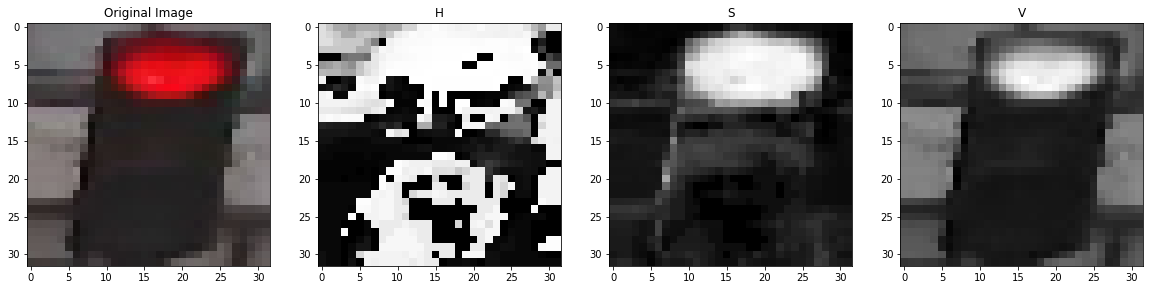

In [78]:
#SAMPLE HSV COLORSPACE FOR A SINGLE IMAGE

image_num = 1
test_im = STANDARD_LIST[image_num][0]
test_label = STANDARD_LIST[image_num][1]

hsv = cv2.cvtColor(test_im, cv2.COLOR_RGB2HSV)

h = hsv[:,:,0]
s = hsv[:,:,1]
v = hsv[:,:,2]

f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(20,10))

ax1.set_title("Original Image")
ax1.imshow(test_im)
ax2.set_title("H")
ax2.imshow(h, cmap='gray')
ax3.set_title("S")
ax3.imshow(s, cmap='gray')
ax4.set_title("V")
ax4.imshow(v, cmap='gray')


In [79]:
#Function to extract feature from the Image
def create_feature(rgb_image):
    
    #Converting the RGB ColorSpace to HSV ColorSpace
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    
     ## TODO: Create and return a feature value and/or vector
    lower_red_1 = np.array([0, 100, 100])
    upper_red_1 = np.array([15, 255, 255])
    red_1 = cv2.inRange(hsv, lower_red_1, upper_red_1)
    
    lower_red_2 = np.array([160, 100, 100])
    upper_red_2 = np.array([180, 255, 255])
    red_2 = cv2.inRange(hsv, lower_red_2, upper_red_2)
    
    red = red_1 + red_2
    
    lower_yellow = np.array([15, 100, 100])
    upper_yellow = np.array([80, 255, 255])
    yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    lower_green = np.array([50, 100, 100])
    upper_green = np.array([100, 255, 255])
    green = cv2.inRange(hsv, lower_green, upper_green)
    
    return red,yellow,green
  

In [80]:
def estimate_label(rgb_image):
    
    predicted_label = [0, 0, 0]
    red, yellow, green = create_feature(rgb_image)
    r = np.sum(red)
    y = np.sum(yellow)
    g = np.sum(green)
    if r >= y and r >= g:
        predicted_label = [1, 0, 0]
    elif y > r and y >= g:
        predicted_label = [0, 1, 0]
    elif g > r and g > y:
        predicted_label = [0, 0, 1]
    return predicted_label     

In [81]:
# Using the load_dataset function in helpers.py
# Load test data
TEST_IMAGE_LIST = helpers.load_dataset(IMAGE_DIR_TEST)

# Standardize the test data
STANDARDIZED_TEST_LIST = standardize(TEST_IMAGE_LIST)

# Shuffle the standardized test data
random.shuffle(STANDARDIZED_TEST_LIST)

In [82]:
# Constructs a list of misclassified images given a list of test images and their labels
# This will throw an AssertionError if labels are not standardized (one-hot encoded)

def get_misclassified_images(test_images):
    # Track misclassified images by placing them into a list
    misclassified_images_labels = []

    # Iterate through all the test images
    # Classify each image and compare to the true label
    for image in test_images:

        # Get true data
        im = image[0]
        true_label = image[1]
        assert(len(true_label) == 3), "The true_label is not the expected length (3)."

        # Get predicted label from your classifier
        predicted_label = estimate_label(im)
        assert(len(predicted_label) == 3), "The predicted_label is not the expected length (3)."

        # Compare true and predicted labels 
        if(predicted_label != true_label):
            # If these labels are not equal, the image has been misclassified
            misclassified_images_labels.append((im, predicted_label, true_label))
            
    # Return the list of misclassified [image, predicted_label, true_label] values
    return misclassified_images_labels


# Find all misclassified images in a given test set
MISCLASSIFIED = get_misclassified_images(STANDARDIZED_TEST_LIST)

# Accuracy calculations
total = len(STANDARDIZED_TEST_LIST)
num_correct = total - len(MISCLASSIFIED)
accuracy = num_correct/total

print('Accuracy: ' + str(accuracy))
print("Number of misclassified images = " + str(len(MISCLASSIFIED)) +' out of '+ str(total))


Accuracy: 0.9158249158249159
Number of misclassified images = 25 out of 297
